# Fridge Appliance Classification Model

### importing libraries and  functions

In [7]:
from xgboost import XGBClassifier,cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,plot_roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import xgboost
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

### Reading the data

In [8]:
train_df =pd.read_csv ('../data/raw/X_train.csv')
test_df = pd.read_csv('../data/raw/X_test_result.csv')

train_df.drop(columns=['Unnamed: 0','Unnamed: 0.1','event_type'],inplace=True)
test_df.drop(columns=['Unnamed: 0','Unnamed: 0.1','event_type'],inplace=True)

train_df.sort_index(axis=1,inplace=True)
test_df.sort_index(axis=1,inplace=True)

### Checking the shape of data

In [9]:
print(train_df.shape)
print(test_df.shape)

(5628, 38)
(2773, 38)


### Data Cleaning

In [10]:
#Fixing nulls and 
train_df.loc[train_df['appliance_name']!='fridge','appliance_name'] = 0
train_df.loc[train_df['appliance_name'].isna(),'appliance_name'] = 0
train_df.loc[train_df['appliance_name']=='fridge','appliance_name'] = 1

test_df.loc[test_df['appliance_name']!='fridge','appliance_name'] = 0
test_df.loc[test_df['appliance_name'].isna(),'appliance_name'] = 0
test_df.loc[test_df['appliance_name']=='fridge','appliance_name'] = 1

In [11]:
# Intitally tried encoding event type, but realized that event type is directly correlated with the appliance name

# # encode string input values as integers
# encode_columns=['event_type']
# encode_df = train_df[encode_columns]
# encode_df = encode_df.astype('str')
# encode_df = encode_df.apply(LabelEncoder().fit_transform)
# train_df_drop = train_df.drop(encode_columns, axis = 1)
# train_df = pd.concat([train_df_drop, encode_df], axis = 1)

# # encode string input values as integers
# encode_columns=['event_type']
# encode_df = test_df[encode_columns]
# encode_df = encode_df.astype('str')
# encode_df = encode_df.apply(LabelEncoder().fit_transform)
# test_df_drop = test_df.drop(encode_columns, axis = 1)
# test_df = pd.concat([test_df_drop, encode_df], axis = 1)

In [12]:
# Replacing null in train data with the median values

na_col_df = pd.DataFrame(train_df.isnull().sum()).reset_index()
na_col_df.columns = ['Column Name','Number of NAs']
list_of_na_cols = na_col_df.loc[na_col_df['Number of NAs']!=0, 'Column Name'].to_list()

for each_col in list_of_na_cols:
    median = train_df[each_col].median()
    train_df.loc[train_df[each_col].isnull(),each_col] = median

In [13]:
# Replacing null in test data with the median values

na_col_df = pd.DataFrame(test_df.isnull().sum()).reset_index()
na_col_df.columns = ['Column Name','Number of NAs']
list_of_na_cols = na_col_df.loc[na_col_df['Number of NAs']!=0, 'Column Name'].to_list()

for each_col in list_of_na_cols:
    median = test_df[each_col].median()
    test_df.loc[test_df[each_col].isnull(),each_col] = median

In [14]:
# creating indenpendent and dependent features
independent_features = ['active_power', 'active_power_delta', 'apparent_power',
       'current','energy','harmonic_ratio_1',
       'harmonic_ratio_2', 'harmonic_ratio_3', 'harmonic_ratio_4',
       'harmonic_ratio_5', 'harmonic_ratio_6', 'harmonic_ratio_7',
       'harmonic_ratio_8', 'harmonic_ratio_9', 'hz', 'phase_shift',
       'reactive_power', 'reactive_power_delta', 'seq_id', 'transient_1',
       'transient_10', 'transient_2', 'transient_3', 'transient_4',
       'transient_5', 'transient_6', 'transient_7', 'transient_8',
       'transient_9', 'voltage',]

dependent_feature = ['appliance_name']

In [15]:
#converting dependent variables to numeric dtype
train_df['appliance_name'] = train_df['appliance_name'].astype(int)
test_df['appliance_name'] = test_df['appliance_name'].astype(int)

In [16]:
#separating dependent and independent variables
X_train = train_df[independent_features]
y_train = train_df[dependent_feature]

X_test = test_df[independent_features]
y_test = test_df[dependent_feature]

In [17]:
# plt.figure(figsize=(14,12))
# sns.heatmap(X_train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
#             square=True,  linecolor='white', annot=True)
# plt.show()

### Models

##### Imports

In [18]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model

from sklearn.model_selection import GridSearchCV

# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

##### Create list of models 

In [19]:
# to feed the random state
seed = 7

# prepare list of classification models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGB', XGBClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'roc_auc' #scoring method 

In [20]:
for name, model in models:
        kfold = KFold(n_splits=5, random_state=seed)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        #appending the mean of the rocs after crossvalidation
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

LR: 0.825108 (0.018673)
LDA: 0.952580 (0.006981)
KNN: 0.601441 (0.011366)
CART: 0.922205 (0.010415)
NB: 0.726822 (0.019289)
RF: 0.986585 (0.004699)
SVM: 0.500000 (0.000000)
[11:22:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:22:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:22:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was ch

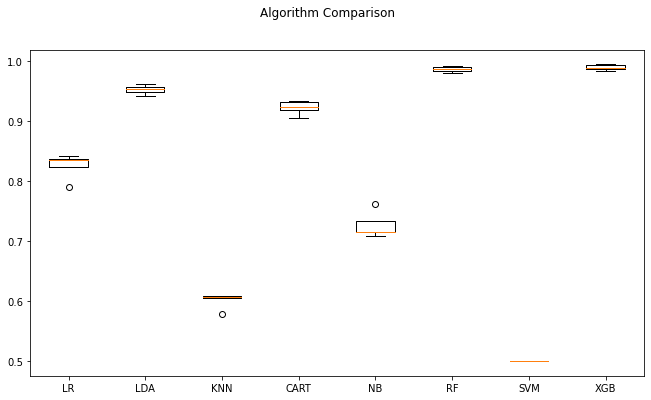

In [21]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [22]:
#Tuning the Hyper Parameters
param_grid = {"max_depth": [10,40],
              "n_estimators":[25,50,100],
              "max_features": [15,30]},

#Creating the classifier
model = RandomForestClassifier(random_state=2)

grid_search = GridSearchCV(model, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=4)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] max_depth=10, max_features=15, n_estimators=25 ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=15, n_estimators=25, score=0.984, total=   0.6s
[CV] max_depth=10, max_features=15, n_estimators=25 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  max_depth=10, max_features=15, n_estimators=25, score=0.988, total=   0.7s
[CV] max_depth=10, max_features=15, n_estimators=25 ..................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  max_depth=10, max_features=15, n_estimators=25, score=0.981, total=   0.6s
[CV] max_depth=10, max_features=15, n_estimators=50 ..................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s


[CV]  max_depth=10, max_features=15, n_estimators=50, score=0.984, total=   1.3s
[CV] max_depth=10, max_features=15, n_estimators=50 ..................
[CV]  max_depth=10, max_features=15, n_estimators=50, score=0.988, total=   1.4s
[CV] max_depth=10, max_features=15, n_estimators=50 ..................
[CV]  max_depth=10, max_features=15, n_estimators=50, score=0.983, total=   1.4s
[CV] max_depth=10, max_features=15, n_estimators=100 .................
[CV]  max_depth=10, max_features=15, n_estimators=100, score=0.984, total=   2.7s
[CV] max_depth=10, max_features=15, n_estimators=100 .................
[CV]  max_depth=10, max_features=15, n_estimators=100, score=0.989, total=   2.9s
[CV] max_depth=10, max_features=15, n_estimators=100 .................
[CV]  max_depth=10, max_features=15, n_estimators=100, score=0.983, total=   2.6s
[CV] max_depth=10, max_features=30, n_estimators=25 ..................
[CV]  max_depth=10, max_features=30, n_estimators=25, score=0.981, total=   1.2s
[CV]

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  1.6min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=2),
             param_grid=({'max_depth': [10, 40], 'max_features': [15, 30],
                          'n_estimators': [25, 50, 100]},),
             scoring='roc_auc', verbose=4)

In [23]:
final_rf_model = grid_search.best_estimator_.fit(X_train,y_train)

In [31]:
y_pred = final_rf_model.predict(X_test)

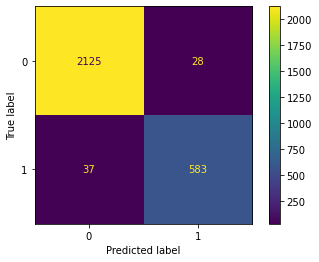

In [25]:
plot_confusion_matrix(final_rf_model,X_test,y_test)

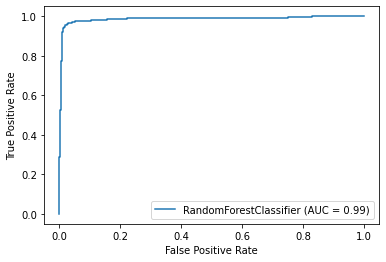

In [26]:
plot_roc_curve(final_rf_model,X_test,y_test)

In [27]:
# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,y_pred)
print('\naccuracy_score on test dataset : ', accuracy_test)


accuracy_score on test dataset :  0.9765596826541652


In [28]:
feature_names = X_train.columns.values.tolist()

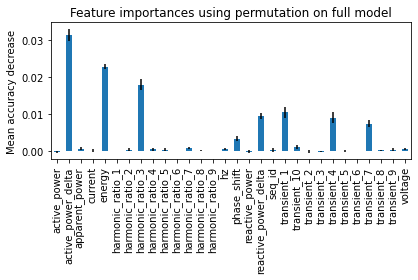

In [29]:
from sklearn.inspection import permutation_importance


result = permutation_importance(
    final_rf_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()